In [7]:
import sys
sys.path.append('unet_backbones')
from unet_backbones.backbones_unet.model.unet import Unet
from unet_backbones.backbones_unet.utils.dataset import SemanticSegmentationDataset
from unet_backbones.backbones_unet.model.losses import DiceLoss
from unet_backbones.backbones_unet.utils.trainer import Trainer
from unet_backbones.backbones_unet.utils.reproducibility import set_seed
from unet_backbones.datasets import VOCSegmentation
from unet_backbones.utils import ext_transforms as et

import os
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from unet_backbones.metrics import StreamSegMetrics

import json
import numpy as np

In [8]:
seed = 42
voc_data_root = "datasets/VOC2012"
voc_crop_size = 256
voc_num_classes = 21
small_decoder = True

save = "experiments"
dataset = "pascalvoc2012"
encoder = "convnext_tiny"
epochs = 150
lr = 1e-4

save_path = os.path.join(save, dataset, encoder, "small_deocder_" + str(small_decoder), "epochs_" + str(epochs), "lr_"+str(lr), 'seed_'+str(seed))
model_path = os.path.join(save_path , "model")
json_path = os.path.join(save_path, "losses.json")
os.makedirs(save_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

In [54]:
def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

In [55]:
label_idx_name = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
                 "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
label_idx_color = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128], 
                   [96, 0, 0], [192, 0, 0], [96, 128, 0], [192, 128, 0], [96, 00, 128], [192, 0, 128], [96, 128, 128], [192, 128, 128], 
                   [0, 96, 0], [128, 96, 0], [0, 192, 0], [128, 192, 0], [0, 96, 128]]

In [56]:
def color_mapping(val):
    label_color = label_idx_color[int(val)]
    return [label_color[0] / 256, label_color[1] / 256, label_color[2] / 256, 0.4]

In [58]:
model = Unet(
    backbone = encoder,
    small_decoder = small_decoder,
    in_channels = 3,
    num_classes = voc_num_classes,
)

# print(model)
# num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print("\n\n\n\t\t\tNUMBER OF PARAMETERS: {}".format(num_params))

In [59]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
model = nn.Sequential(Normalize(mean = mean, std = std), model)

In [60]:
path = os.path.join(model_path, "final_model.pt")
print(path)

checkpoint = torch.load(path, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])

experiments/pascalvoc2012/convnext_tiny/small_deocder_True/epochs_150/lr_0.0001/seed_42/model/final_model.pt


<All keys matched successfully>

In [61]:
val_transform = et.ExtCompose([
                et.ExtResize(voc_crop_size),
                et.ExtCenterCrop(voc_crop_size),
                et.ExtToTensor(),
            ])
test_dst = VOCSegmentation(root = voc_data_root, 
                        year = "2012",
                        image_set='test', 
                        download = True, 
                        transform = val_transform)

Using downloaded and verified file: datasets/VOC2012/VOCtrainval_11-May-2012.tar


In [62]:
print(test_dst.__len__())

5


In [113]:
idx = 2

raw_img, raw_mask = test_dst.get_raw_img(idx)

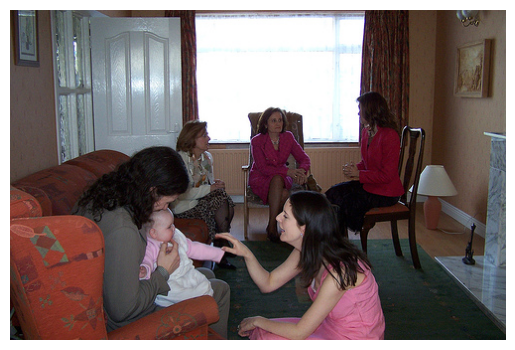

In [114]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 加载本地图片
img = mpimg.imread(raw_img)

# 创建图形
plt.imshow(img)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [115]:
model.to(get_device()).eval()
img, label = test_dst.__getitem__(idx)
img_tensor = img.to(get_device())
preds = model(img_tensor.unsqueeze(0))

In [116]:
pred_label = torch.argmax(preds[0], dim=0)
array = pred_label.cpu().numpy()
overlay = np.apply_along_axis(color_mapping, -1, array.reshape(-1, 1)).reshape(256, 256, 4)

/tmp/ipykernel_1515/2368875369.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_color = label_idx_color[int(val)]


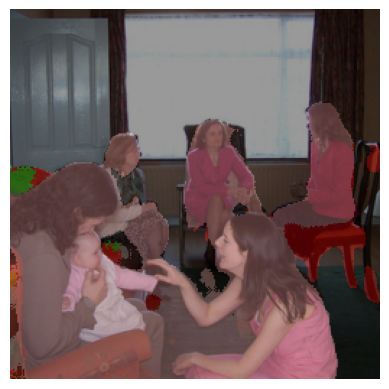

In [117]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

show_transform = et.ExtCompose([
                et.ExtResize(voc_crop_size),
                et.ExtCenterCrop(voc_crop_size)
            ])

# 加载本地图片
img = Image.open(raw_img)
lbl = Image.open(raw_mask)
img_resized, _ = show_transform(img, lbl)

# 创建图形
fig, ax = plt.subplots()
ax.imshow(img_resized)
ax.imshow(overlay, alpha=1)

plt.axis('off')  # 关闭坐标轴
plt.show()

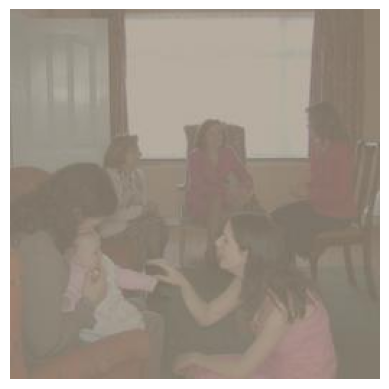

In [130]:
adv_img_path = "experiments/pascalvoc2012/convnext_tiny/small_deocder_True/epochs_1/lr_0.0001/seed_42/attack/cospgd/inf/500/perturbed_best_image_" + str(idx) + ".jpg"

# 加载攻击后图片
adv_img = mpimg.imread(adv_img_path)

plt.imshow(adv_img)
plt.axis('off')
plt.show()

In [131]:
import torchvision.transforms.functional as F

adv_img_tensor = F.to_tensor(adv_img).to(get_device())
adv_preds = model(adv_img_tensor.unsqueeze(0))

/tmp/ipykernel_1515/2368875369.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_color = label_idx_color[int(val)]


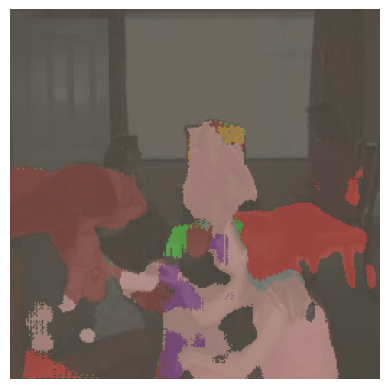

In [132]:
adv_pred_label = torch.argmax(adv_preds[0], dim=0)
adv_array = adv_pred_label.cpu().numpy()
adv_overlay = np.apply_along_axis(color_mapping, -1, adv_array.reshape(-1, 1)).reshape(256, 256, 4)

# 创建图形
fig, ax = plt.subplots()
ax.imshow(adv_img)
ax.imshow(adv_overlay, alpha=1)

plt.axis('off')  # 关闭坐标轴
plt.show()